## Load the data

In [1]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from scipy.stats import nbinom, poisson
from time import sleep
from tqdm import tqdm
import warnings

# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])

country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

check for possible Nan's in all Datasets

In [2]:
# check for nan's
for featurelist in features_df_list:
    is_na_series = featurelist['data'].isna().sum()

    for i in range(len(is_na_series)):
        if is_na_series[i] > 0 :
            print(str(is_na_series.index[i]) + ': ' + str(is_na_series[i]))

# wichtig:
analog zur baseline code implementieren, der abfängt, dass auch für jedes Land der letzte Monat vor Jan 2018 verfügbar ist und insgesamt genug Monate vorhanden sind, um mit w_max den train, valid, test Split zu machen

z.b. 246 viel zu wenig Monate für w = 48?!

## Feed forward Neural Net
Goal is to estimate the empirical distribution of the fatalities per month.

### CRPS Loss function
CRPS for samples from random variables with a finite first moment.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
import matplotlib.pyplot as plt
import seaborn as sns

# crps loss function 
def crps(y_true, S):
    """
    Computes continuous ranked probability score:

    Parameters
    ----------
    y_true : tf tensor of shape (BATCH_SIZE, 1)
        True values.
    S : tf tensor of shape (BATCH_SIZE, N_SAMPLES)
        Predictive samples.

    Returns
    -------
    tf tensor of shape (BATCH_SIZE,)
        Scores.

    """
    beta=1
    n_samples = S.shape[-1]
    def expected_dist(diff, beta):
        return K.sum(K.pow(K.sqrt(K.square(diff)+K.epsilon()), beta),axis=-1) #axis = -1: last dimension <=> N_SAMPLES
    es_1 = expected_dist(y_true - S, beta)
    es_2 = 0
    for i in range(n_samples):
        es_2 = es_2 + expected_dist(K.expand_dims(S[:,i]) - S, beta)
    return es_1/n_samples - es_2/(2*n_samples**2)

class CRPSLoss(Loss):
    def call(self, y_true, S):
        return crps(y_true, S)

### Data preparation for the Neural Net

In [4]:
### prediction task for country 223 and actual year 2018
prediction_year = '2018'
dataset_index = actual_years.index(prediction_year)
prediction_country_id = 223

## load datasets
feature_data = country_feature_group_list[dataset_index].get_group(prediction_country_id)
actual_data = country_actual_group_list[dataset_index].get_group(prediction_country_id)

# numbers of months from the feature dataset
month_list_feature_data = feature_data.index.get_level_values('month_id').tolist()
number_months_feature_data = len(month_list_feature_data) 
first_month = month_list_feature_data[0]
last_month = month_list_feature_data[-1]

## split data in train-, validation- and test-dataset



## the maximal window length used for training is calculated from the minimal sample size and the
# available months for the country. E.g. there have to be 
# at least 30 samples (i.e. the number of rolling windows/ iterations thru the train dataset )

######################################
minimal_sample_size = 40 ## == NUMBER SAMPLES IF COUNTRY HAS ALL MONTS (TILL 121) AND W = 48!!
######################################

numberWindows = numberMonths_toOct20 - (w + 2 + 12)


def windowLength(w):
    return w + 2 +12

def number_train_months(numberMonths_available, windowLength, w):
    return numberMonths_available - windowLength - w

def number_samples(numberMonths_available, windowLength, w):
    return number_train_months(numberMonths_available, windowLength, w) - windowLength(w)

def get_maximal_windowlen(numberSamples_required, numberMonths_available):

    w_max = 1
    sampleSize = number_samples(numberMonths_available, windowLength(w_max), w_max)

    while sampleSize <= numberSamples_required:
        
        
        
        print(i)
        i += 1


    windowLength = w + 2 + 12 # length of the individual window for the current w
    number_train_months = numberMonths_available - windowLength - w
    numberSamples_required = number_train_months - windowLength


    return w_max


w_max = 48 # maximum number of months used for one training run




# length of the maximum rolling window and the used "unreal" acutals starting 3 months after the last used month
roll_estim_window_len = w_max + 2 + 12 

# training dataset
last_month_train = last_month - w_max - 12-2-w_max 
data_train = feature_data.loc[(slice(first_month, last_month_train), slice(None)), :] # including "unreal" actuals

## validation and test dataset
# both of them are designed, so that there are exactly w months as input
# validation dataset
last_month_valid = last_month - w_max
data_validate = feature_data.loc[(slice(last_month_train+1, last_month_valid), slice(None)), :] # including "unreal" actuals

# test dataset
data_test = feature_data.loc[(slice(last_month_valid+1, last_month), slice(None)), :] # no "unreal" actuals and real actuals not included as well

In [30]:
# length of a whole window (containing w input months and 12 acutal months)
def rollingWindowLength(w):
    return w + 2 + 12

# number of months available for training (after removing the validation and test months)
def number_train_months(numberMonths_available, w):
    rollingWindowlen = rollingWindowLength(w)
    #  all months feature data     validate set          test set input
    return numberMonths_available - rollingWindowlen - w

# number of training samples (rolling windows)
def number_train_samples(numberMonths_available, w):
    rollingWindowlen = rollingWindowLength(w)
    return number_train_months(numberMonths_available, w) - rollingWindowlen

def get_maximal_w(numberSamples_required, numberMonths_available):

    w_max = 1

    if number_train_samples(numberMonths_available, w_max) < numberSamples_required:
        return 'not enough months for ' + str(numberSamples_required) + ' required samples'
         

    sampleSize = number_train_samples(numberMonths_available, w_max)

    while sampleSize > numberSamples_required:
        w_max += 1
        sampleSize = number_train_samples(numberMonths_available, w_max)

    return w_max

In [32]:
w = 4
required_samples = 40
available_months = 70
get_maximal_w(required_samples, available_months)


'not enough months for 40 required samples'

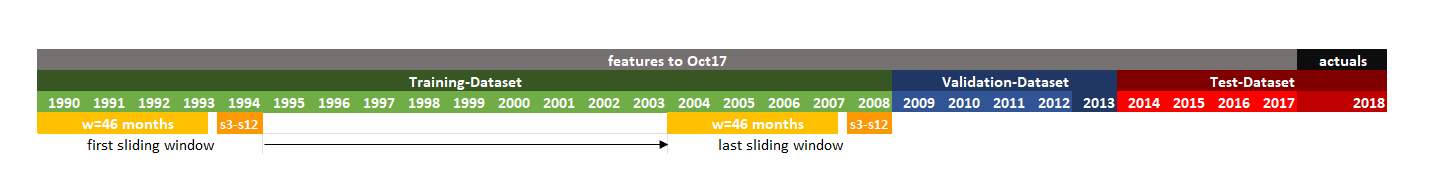

### Rolling window split for the current windowlength w
As shown in the picture above, the training dataset is genereated via a rolling window approach.
**One sample contains:**
*  features of w months, concatenated to one vector with the dimension *w * number_of_features*
*  one true observation, dependent of the current s that is estimated in the NN, e.g. y_true = s3 = 54.

So one entire training sample for a w contains a different amount of samples, dependent from the windowlength and the available number of observations of the country.

In [ ]:
#calculate the number of subsets, that are used to estimate the distribution and validate it via 12 months of actuals 
# the number is dependent of the actual w. E.g. with the maximal w (e.g. 24): if w=24, actuals are 12 months (starting with s=3 to s=14) 
# -> 24 + 2 + 12 = 39 observations of ged_sb per window
# so if the dataset has 96 observations there are 96 - 38 = 58 shiftable windows for 2020
numberWindows = numberMonths_toOct20 - (w + 2 + 12)

windowLength = w + 2 + 12 # length of the individual window for the current w


# loop through all X equal parts of the feature dataset (traindata length w, actuals is vector of the next t+3 till t+12 observations)
for j in range(numberWindows):
    starting_month_window = last_month - windowLength + 1 - numberWindows + 1  + j
    ending_month_window = starting_month_window + w - 1

    starting_month_actuals = ending_month_window + 3
    ending_month_actuals = starting_month_actuals + 11
    
    window_features = features.loc[(slice(starting_month_window, ending_month_window), slice(None)), 'ged_sb']
    window_actuals = features.loc[(slice(starting_month_actuals, ending_month_actuals), slice(None)), 'ged_sb']
    

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.compat.v2.enable_v2_behavior()
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam


from scipy.stats import nbinom

# Funktion für die ReLU-Transformation
def relu_transform(x):
    return tf.nn.relu(x)


## hyperparameters
batch_size = 1 # defines the number of samples to work through before 
# updating the internal model parameters (sample = (1 inputvector, 1 y_true))
epoch = 10 # defines the number times that the learning algorithm will work through the entire training dataset
# -> line plots that show epochs along the x-axis as time and the error or skill of the model on the y-axis (= learning curve)




number_features = 10
len_features = 32

input_shape = (number_features*len_features,) # Number of used features   10 * 32
# z.B.
""" [
  [1, 2, 3, ..., 10],   # Datenpunkt 1 mit 10 features
  [11, 12, 13, ..., 20],  # Datenpunkt 2 mit 10 features
  ...
  [311, 312, 313, ..., 320]  # Datenpunkt 32 mit 10 features
] """


# Define inputs with predefined shape
inputs = Input(shape=input_shape)

# print(inputs.shape) -> (None, 10, 32) no Batch size defined (more flexible)

hidden_layer1 = Dense(20, activation='relu')(inputs) 
# Dense Layer: the 10 neurons in the dense layer get their source of input data 
# from all the other neurons of the previous layer of the network (= fully connected layer)
#hidden_layer2 = Dense(8, activation='relu')(hidden_layer1) 

# Predict the parameters of a negative binomial distribution
output_s3 = Dense(200)(hidden_layer1) # neurons for n and p
sample_output_s3 = Lambda(relu_transform)(output_s3) # n and p are transformed, so that they fulfill the constraints

# Construct model
model = Model(inputs=inputs, outputs=sample_output_s3, name = 'simple_NN_empirical')

# Compile the model with the desired optimizer, loss function, etc.
model.compile(optimizer=Adam(learning_rate=0.001), loss=CRPSLoss())
#model.compile(optimizer=Adam(learning_rate=0.001), loss=negative_binomial_loss)


# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense (Dense)               (None, 20)                6420      
                                                                 
 dense_1 (Dense)             (None, 200)               4200      
                                                                 
 lambda (Lambda)             (None, 200)               0         
                                                                 
Total params: 10620 (41.48 KB)
Trainable params: 10620 (41.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
from sklearn import model_selection, preprocessing

used_features = feature_data.iloc[:,2:12].tail(32)
used_features_norm = preprocessing.normalize(used_features)

x_train  = np.array([used_features_norm.flatten()])
y_train = np.array([70.0])

history = model.fit(x_train, y_train)   #, batch_size=64, epochs=2

""" test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1]) """

1/1 [==============================] - 54s 54s/step - loss: 69.9423


' test_scores = model.evaluate(x_test, y_test, verbose=2)\nprint("Test loss:", test_scores[0])\nprint("Test accuracy:", test_scores[1]) '